In [3]:
import numpy as np
from scipy.stats import gaussian_kde, norm, expon, uniform, gamma

import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import clear_output

### EM-алгоритм

В качестве примера использования EM-алгоритма будет ставиться задача восстановления параметров нормальных распределений (математических ожиданий, дисперсий) из их смеси

При этом для каждого распределения также будет находиться доля объектов из данного распределения в смеси



In [4]:
mu = np.array([2, 1, 0.5, 2.5])
std = np.array([1, 0.8, 0.75, 0.3])
sizes = np.array([400, 600, 200, 800])
assert mu.shape[0] == std.shape[0] and std.shape[0] == sizes.shape[0], 'Mathematical expectations, standard deviations an sizes of samples must have the same size'
k = mu.shape[0]

Напишем функцию, которая получает из математических ожиданий, стандартных отклонений и размеров выборок смесь

In [5]:
def get_mixture(mu, stda, sizes):
    X = np.array([])
    for local_mu, local_std, local_size in zip(mu, std, sizes):
        X = np.concatenate((X, np.random.normal(local_mu, local_std, size=local_size)))
    return X

In [6]:
X = get_mixture(mu, std, sizes)

Следующая функция по аргументу, математическому ожиданию и стандартному отклонению вовзращает плотность вероятности нормального распределения в этой точке

Напишем функцию, осуществляющую процедуру, описанную в начале ноутбука

In [7]:
def EM(X, k, num_epochs, verbose=False):
    N = X.shape[0]
    borders = np.concatenate(([0], np.cumsum(np.histogram(range(N), bins=k)[0])))
    slices = np.array([slice(borders[i], borders[i + 1]) for i in range(k)])
    parts = [X[local_slice] for local_slice in slices]
    mu = np.array([np.mean(part) for part in parts])
    std = np.array([np.std(part) for part in parts])
    w = np.ones(k) / k
    log_likelihoods = []

    for epoch in range(1, num_epochs + 1):
        H = np.empty([N, 0])
        for local_mu, local_std, local_w in zip(mu, std, w):
            H = np.hstack((H, local_w * norm.pdf(X, loc=local_mu, scale=local_std)[:, np.newaxis]))
        H /= np.repeat(np.sum(H, axis=1)[:, np.newaxis], k, 1)


        X_repeated = np.repeat(X[:, np.newaxis], k, 1)
        H_sum = np.sum(H, axis=0)
        mu = np.sum(H * X_repeated, axis=0) / H_sum
        std = np.sqrt(np.sum(H * np.square(X_repeated - mu), axis=0) / H_sum)
        w = np.mean(H, axis=0)

        likelihood = np.zeros_like(X)
        for local_mu, local_std, local_w in zip(mu, std, w):
            likelihood += local_w * norm.pdf(X, loc=local_mu, scale=local_std)
        log_likelihood = np.sum(np.log(likelihood))
        log_likelihoods.append(log_likelihood)

        if verbose and (epoch - 1) % verbose == 0:
            clear_output(wait=True)
            plt.plot(range(1, epoch + 1), log_likelihoods)
            plt.grid()
            plt.xlabel('Эпоха')
            plt.ylabel('Логарифм правдоподобия')
            plt.title('Логарифм правдоподобия в зависимости от эпохи')
            plt.show()

    return mu, std, w

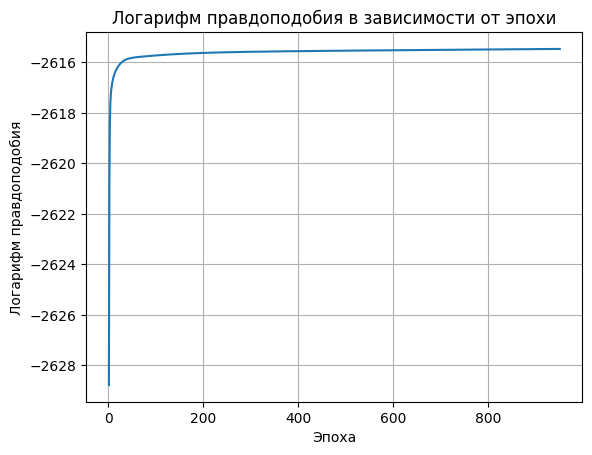

In [8]:
num_epochs = 1000
new_mu, new_std, new_w = EM(X, k, num_epochs, verbose=50)

In [9]:
print(f'Найденные математические ожидания: {new_mu}')
print(f'Процентные разности между найденными и истинными математическими ожиданиями: {np.abs((mu - new_mu) / mu)}')

Найденные математические ожидания: [2.17045004 0.95375723 1.01378468 2.53568811]
Процентные разности между найденными и истинными математическими ожиданиями: [0.08522502 0.04624277 1.02756936 0.01427524]


In [10]:
print(f'Найденные стандартные отклонения: {new_std}')
print(f'Процентные разности между найденными и истинными стандартными отклонениями: {np.abs((std - new_std) / std)}')

Найденные стандартные отклонения: [0.87790728 0.70612354 1.01049358 0.26846664]
Процентные разности между найденными и истинными стандартными отклонениями: [0.12209272 0.11734557 0.34732477 0.10511121]


In [11]:
print(f'Найденные доли распределений: {new_w}')
w = sizes / np.sum(sizes)
print(f'Процентные разности между найденными и истинными долями распределений: {np.abs((w - new_w) / w)}')

Найденные доли распределений: [0.18097979 0.26173546 0.19276214 0.36452261]
Процентные разности между найденными и истинными долями распределений: [0.09510106 0.12754846 0.92762137 0.08869347]


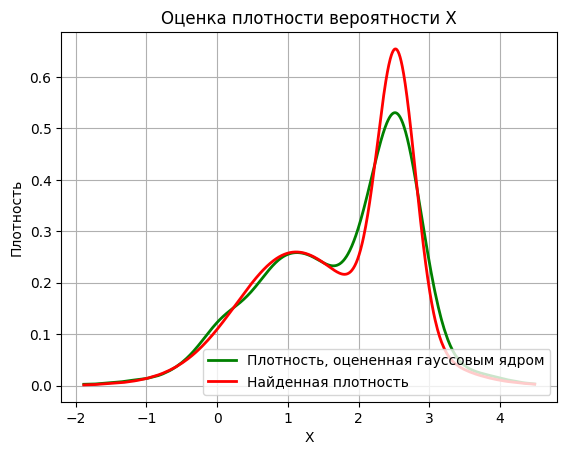

In [12]:
X_sorted = np.sort(X)
density_estimation = np.zeros_like(X)
for local_mu, local_std, local_w in zip(new_mu, new_std, new_w):
    density_estimation += local_w * norm.pdf(X_sorted, loc=local_mu, scale=local_std)
plt.plot(
    X_sorted, gaussian_kde(X_sorted)(X_sorted), color='green',
    label='Плотность, оцененная гауссовым ядром',
    linewidth=2
)
plt.plot(
    X_sorted, density_estimation, color='red', label='Найденная плотность',
    linewidth=2
)
plt.xlabel('X')
plt.ylabel('Плотность')
plt.title('Оценка плотности вероятности X')
plt.grid()
plt.legend()
plt.show()

**Вывод**: одним из главных недостатков EM-алгоритма является то, что он застревает в локальных минимумах

По-видимому, это и произошло при поиске математических ожиданий и стандартных отклонений нормальных распределений. Например, для 3 распределения ошибка при нахождении математического ожидания равняется примерно 185%, а логарифм правдоподобия после некоторого небольшого количества начальных эпох уже не менялся

### Ядерное сглаживание

Определим функцию, которая применяет различные ядерные функции для восстановления плотности:
* Равномерное ядро
* Треугольное ядро
* Ядро Епанечникова
* Биквадратное ядро
* Гауссовское ядро

In [13]:
def KDE(X, points, h, kernel='Гауссово ядро'):
    X = np.repeat(X[:, np.newaxis], points.shape[0], 1)
    u = (X - points) / h
    match kernel:
        case 'Равномерное ядро':
            S = np.mean((np.abs(u) <= 1).astype(float) / 2, axis=0)
        case 'Треугольное ядро':
            S = np.mean(1 - np.abs(np.clip(u, a_min=-1, a_max=1)), axis=0)
        case 'Ядро Епанечникова':
            S = 0.75 * np.mean(1 - np.square(np.clip(u, a_min=-1, a_max=1)), axis=0)
        case 'Биквадратное ядро':
            S = 0.9375 * np.mean(np.square(1 - np.square(np.clip(u, a_min=-1, a_max=1))), axis=0)
        case 'Гауссово ядро':
            S = np.mean(norm.pdf(u), axis=0)
    S /= h
    return S

Объявим названия ядер, а также функцию для отрисовки результатов сглаживания

In [14]:
kernels = [
    'Равномерное ядро', 'Треугольное ядро', 'Ядро Епанечникова',
    'Биквадратное ядро', 'Гауссово ядро'
]

In [15]:
def plot_kernels(
    distribution, generated, h, title, kernels=kernels, distribution_params={},
    figsize=(12, 7)
):
    points = np.linspace(generated.min(), generated.max(), generated.shape[0])
    _, ax = plt.subplots(figsize=figsize)
    plt.plot(points, distribution.pdf(points, **distribution_params), label='Истинная плотность')
    for kernel, local_h in zip(kernels, h):
        plt.plot(points, KDE(generated, points, local_h, kernel=kernel), label=f'{kernel} (h={local_h})')
    plt.grid()
    plt.legend()
    plt.title(title)
    plt.show()

#### Нормальное распределение

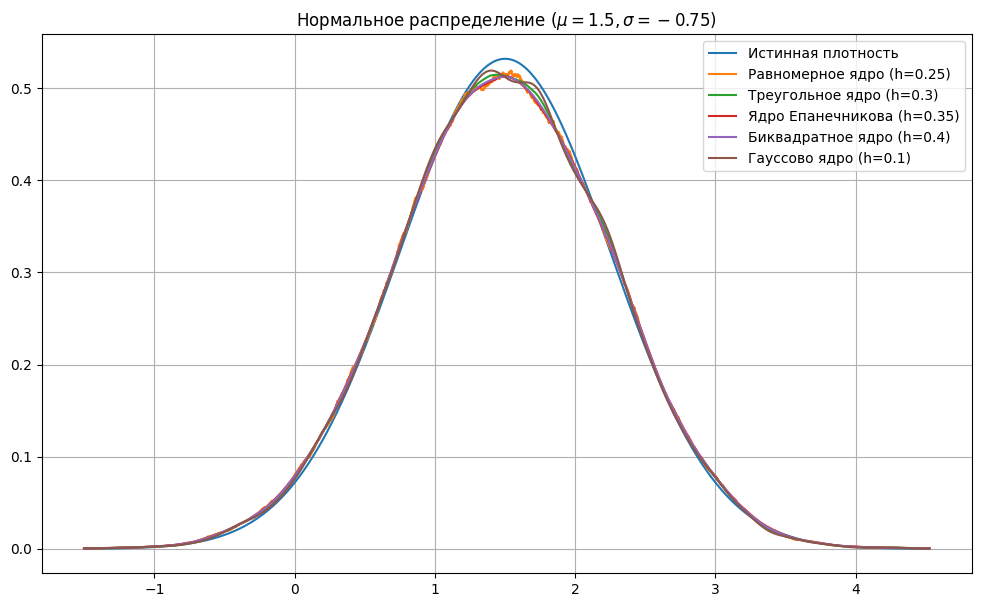

In [16]:
plot_kernels(
    norm, np.random.normal(1.5, 0.75, size=10000), [0.25, 0.3, 0.35, 0.4, 0.1],
    'Нормальное распределение $(\mu=1.5, \sigma=-0.75)$', distribution_params={
        'loc': 1.5, 'scale': 0.75
    }
)

Что ж, все ядра справились очень хорошо, на хвостах распределения так вообще почти идеально совпадают с истинной плотностью

#### Равномерное распределение

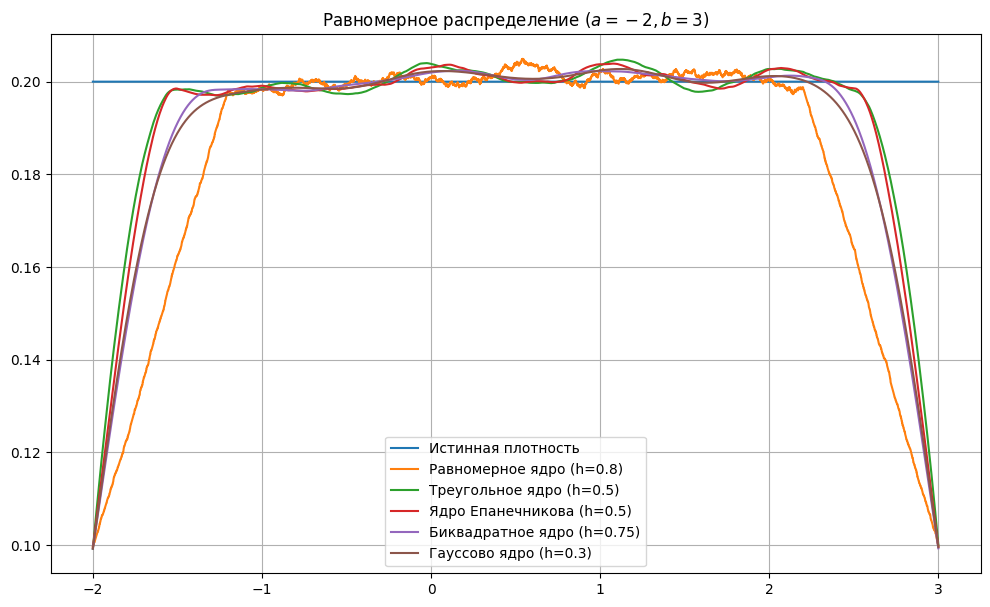

In [17]:
plot_kernels(
    uniform, np.random.uniform(-2, 3, size=10000), [0.8, 0.5, 0.5, 0.75, 0.3],
    'Равномерное распределение $(a=-2, b=3)$', distribution_params={
        'loc': -2, 'scale': 5
    }
)

Здесь ситуация похуже, так как около граничных точек (-3 и 2) полученные плотности сильно занижены по равнению с исходной. Объяснение этому заключается в том, что около этих самых точек было сгенерировано немного значений, а для точного восстановления плотности нужно как можно больше экземпляров

#### Экспоненциальное распределение

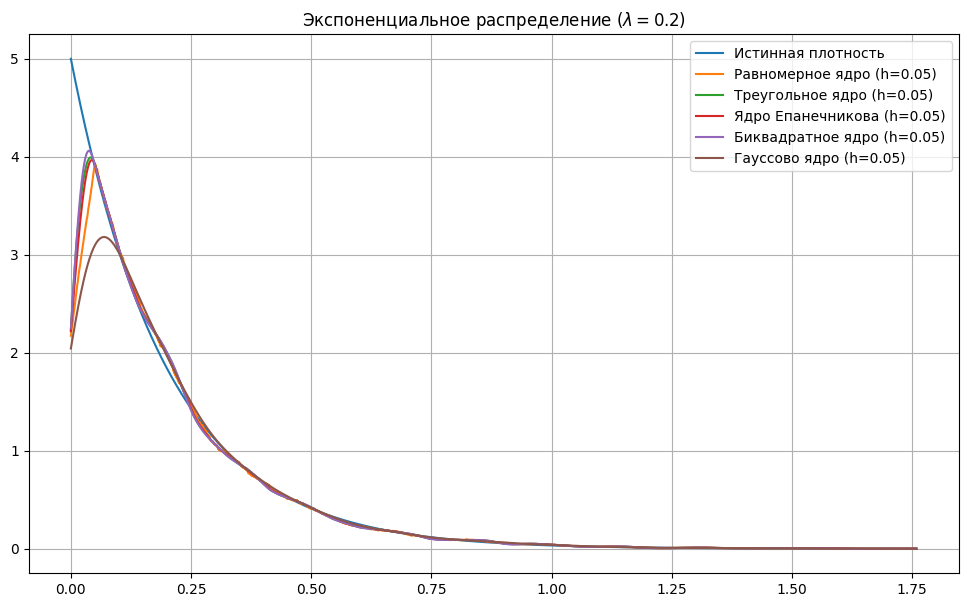

In [18]:
plot_kernels(
    expon, np.random.exponential(scale=0.2, size=10000), [0.05] * 5,
    'Экспоненциальное распределение $(\lambda = 0.2)$', distribution_params={
        'scale': 0.2
    }
)

Здесь хорошо аппроксимируется хвост распределения, но плотность около нуля занижена по сравнению с истинной. Объяснение точно такое же, как и в случае равномерного распределения - около нуля сгенерировано не очень много точек, и поэтому все плотности идут вниз, а не вверх, как должны

#### Гамма-распределение

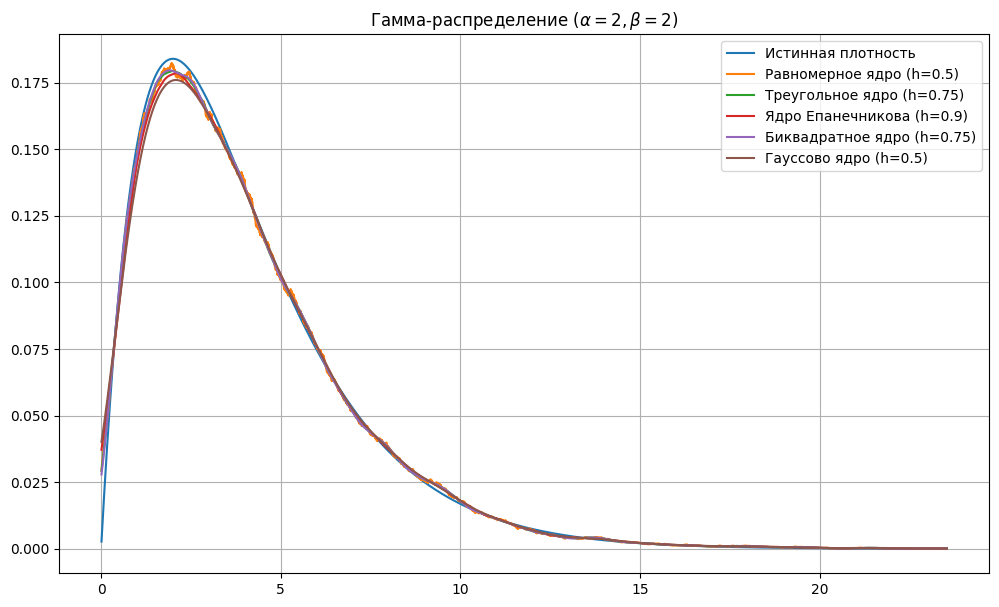

In [50]:
plot_kernels(
    gamma, np.random.gamma(shape=2, scale=2, size=10000), [0.5, 0.75, 0.9, 0.75, 0.5],
    f'Гамма-распределение $(\\alpha=2, \\beta=2)$', distribution_params={
        'a': 2, 'scale': 2
    }
)

Как и у нормального распределения, хвосты очень хорошо аппроксимируются, есть лишь некоторые трудности с "куполом" (восстанволенные плотности чуть занижены по сравнению с истинной)

### Выводы

В данной лабораторной работе я реализовал на практие одну из разновидностей EM-алгоритма, которая находит параметры нормальных распределений из их смеси, а также реализовал несколько методов ядерного сглаживания и протестировал их на 3 различных непрерывных распределениях

1) В качестве распределения EM-алгоритма было выбрано нормальное, так как не пришлось решать задачу оптимизации по подбору оптимальных параметров распределения. Одной из неприятных особенностей EM-алгоритма является то, что его результат очень сильно зависит от начального приближения, возможно результаты получились не очень удовлетворительные из-за этого

2) Методы ядерного сглаживания лучше всего показали себя на нормальном и гамма- распределениях, хуже - на равномерном и экспоненицальном. Причины были описаны во время проведения этих экспериментов